## Load Dataset:

In [1]:
import pandas as pd
df = pd.read_csv('archive/Summary of Weather.csv', parse_dates=["Date"])
df.head()

/Users/alessandroferi/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-07-01,1.016,NaN,25.555556,22.222222,23.888889,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-07-02,0,NaN,28.888889,21.666667,25.555556,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-07-03,2.54,NaN,26.111111,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-07-04,2.54,NaN,26.666667,22.222222,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-07-05,0,NaN,26.666667,21.666667,24.444444,0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Inspect the content of the dataset identifying if there are missing values for the sensors in the dataset, checking for the top 10 most complete sensors (in terms of collected data) the distribution of the recorded mean temperatures (MeanTemp column)

In [2]:
df.groupby("STA").size().sort_values(0, ascending=False).head(10)

STA
22508    2192
10701    2185
22502    2154
22504    2118
10803    1750
11610    1631
16405    1622
11601    1604
10502    1527
11604    1514
dtype: int64

Filter the data by STA (Station) and extract the mean temperature measurements corresponding to sensor with id 22508


In [3]:
# new index for our dataset:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

In [4]:
mtemps = df[df["STA"] == 22508]["MeanTemp"]
mtemps.head(5)

Date
1940-01-01    20.000000
1940-01-02    19.444444
1940-01-03    20.000000
1940-01-04    21.111111
1940-01-05    18.333333
Name: MeanTemp, dtype: float64

Now you should have an array containing all the measurements collected by sensor 22508 representing the time series of the mean temperatures. Plot the temperatures time series exploiting matplotlib and show on the x axis the corresponding datetimes

<IPython.core.display.Javascript object>


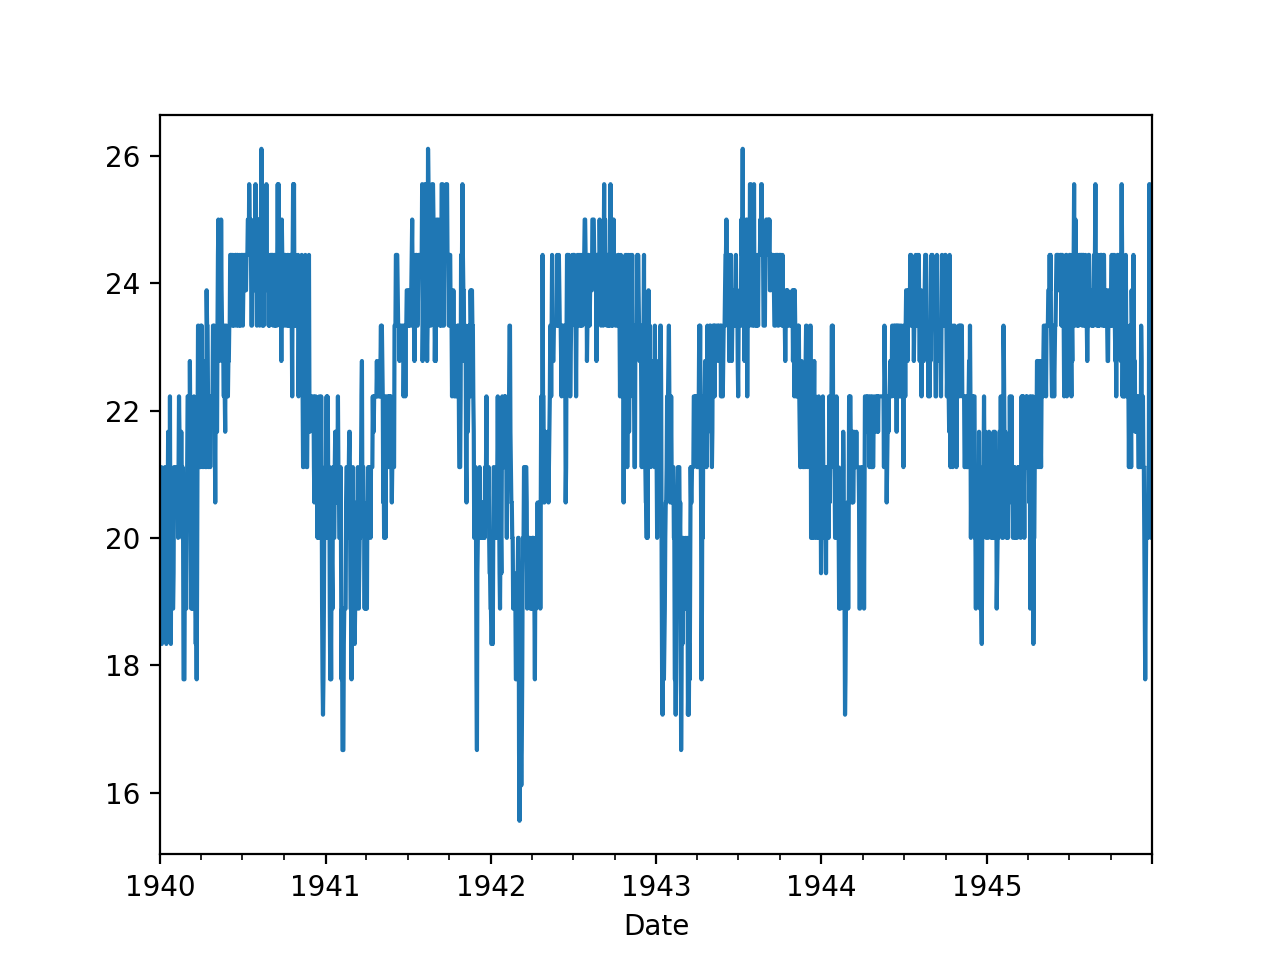

<AxesSubplot:xlabel='Date'>

In [28]:
import matplotlib.pyplot as plt 
%matplotlib notebook
fig, ax = plt.subplots()
mtemps.plot(ax=ax)


To predict the next day temperature, arolling window pre-processing should be performed to convert the time series into a structured dataset. The rolling windows on the time series can be applied by extracting, from the original time series, a window of length W that moves over the series, with step 1


In [6]:
W=3
X = list() 
y = list()

In [7]:
for i in range(mtemps.size - W): # range: [0, mtemps.size - W - 1] 
    X.append(mtemps.iloc[i:i + W].values.T) # transpose to create a row array 
    y.append(mtemps.iloc[i + W])
# transform the structured representation into numpy arrays
X = np.array(X)
y = np.array(y)
X.shape, y.shape

NameError: name 'np' is not defined

check the rolling window:

In [8]:
mtemps[:5]

Date
1940-01-01    20.000000
1940-01-02    19.444444
1940-01-03    20.000000
1940-01-04    21.111111
1940-01-05    18.333333
Name: MeanTemp, dtype: float64

In [9]:
X[:3,:]

TypeError: list indices must be integers or slices, not tuple

In [10]:
y[:3]

[21.11111111, 18.33333333, 20.0]

###  6
Split the dataset into train and test sets and keep in mind that you are evaluating the forecasting of a time series. To train your model you can consider to use the data from 1940 to 1944 and test the trained models on 1945 data. A different way of performing the cross validation on time series is the TimeSeriesSplit strategy available in Scikit-learn.

In [11]:
X_df = pd.DataFrame(X, index=mtemps.index[:mtemps.size - W],
                    columns=["t0", "t1", "t2"])
X_df.head()

,t0,t1,t2
Date,,,
1940-01-01,20.000000,19.444444,20.000000
1940-01-02,19.444444,20.000000,21.111111
1940-01-03,20.000000,21.111111,18.333333
1940-01-04,21.111111,18.333333,20.000000
1940-01-05,18.333333,20.000000,20.555556


In [12]:
y_s = pd.Series(y, index=mtemps.index[:mtemps.size - W])
y_s.head()

Date
1940-01-01    21.111111
1940-01-02    18.333333
1940-01-03    20.000000
1940-01-04    20.555556
1940-01-05    18.888889
dtype: float64

In [13]:
X_train, y_train = X_df.loc["1940":"1944"], y_s.loc["1940":"1944"]
X_train.index

DatetimeIndex(['1940-01-01', '1940-01-02', '1940-01-03', '1940-01-04',
               '1940-01-05', '1940-01-06', '1940-01-07', '1940-01-08',
               '1940-01-09', '1940-01-10',
               ...
               '1944-12-22', '1944-12-23', '1944-12-24', '1944-12-25',
               '1944-12-26', '1944-12-27', '1944-12-28', '1944-12-29',
               '1944-12-30', '1944-12-31'],
              dtype='datetime64[ns]', name='Date', length=1827, freq=None)

In [14]:
from datetime import date
initial_day = date(1944, 12, 31) + pd.Timedelta(f"{W} days") 
initial_day

datetime.date(1945, 1, 3)

In [15]:
X_test, y_test = X_df.loc[initial_day:], y_s.loc[initial_day:]
X_test.shape

(360, 3)

Now,using the regression techniques, try to identify which is the most accurate regression model evaluating the r2_score and the mean_squared_error.

In [23]:
from sklearn.linear_model import LinearRegression 
from sklearn.neural_network import MLPRegressor 
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import Ridge
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures 
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import r2_score

In [21]:
from prettytable import PrettyTable
degree = 5
models = [
    LinearRegression(),
    Ridge(random_state=42),
    MLPRegressor(hidden_layer_sizes=(10,), random_state=42, max_iter=10000),
    MLPRegressor(hidden_layer_sizes=(10,10),  activation='tanh', solver='lbfgs', 
                 shuffle=True, alpha=0.000, batch_size='auto', 
                 learning_rate='constant',learning_rate_init=0.01, 
                 power_t=0.5, max_iter=10000, random_state=42, tol=0.0001, 
                 verbose=True, warm_start=False, momentum=0.0, 
                 nesterovs_momentum=False, early_stopping=False, validation_fraction=0.0, 
                 beta_1=0.9, beta_2=0.999, epsilon=1e-08), SVR(gamma='scale'), 
                 RandomForestRegressor(n_estimators=300),
        make_pipeline(
            make_column_transformer(
                (FunctionTransformer(np.sin), [0]),
                (PolynomialFeatures(degree), [0])
            ),
            LinearRegression()
        ),
        make_pipeline(
            make_column_transformer(
                (FunctionTransformer(np.sin), [0]),
                (PolynomialFeatures(degree), [0])
            ),
        Ridge(alpha=1)
        )
]
names = [
    'linreg',
    'ridge',
    'mlp_standard',
    'mlp_tuned',
    'svr',
    'rf', 
    f'sin+poly{degree}+linreg',
    f'sin+poly{degree}+ridge'
]

In [24]:
t = PrettyTable()
t.field_names = ['model', 'MSE', 'R2']
for model, name in zip(models, names): 
    model.fit(X_train, y_train)
    y_hat = model.predict(X_test)
    mse = mean_squared_error(y_test, y_hat) 
    r2 = r2_score(y_test, y_hat) 
    t.add_row([name, mse, r2])
print(t)

+------------------+--------------------+-----------------------+
|      model       |        MSE         |           R2          |
+------------------+--------------------+-----------------------+
|      linreg      | 0.7708838668711105 |   0.6684666582498318  |
|      ridge       | 0.7708190312576366 |   0.6684945420446848  |
|   mlp_standard   | 0.7756832982117086 |   0.6664025710646799  |
|    mlp_tuned     | 2.4075308874873915 | -0.035404676109139555 |
|       svr        | 0.7606632382515228 |   0.6728622349464781  |
|        rf        | 0.8403880397178332 |   0.6385750602027968  |
| sin+poly5+linreg |  1.1396245117009   |   0.5098826957708611  |
| sin+poly5+ridge  | 1.1393130364199673 |   0.5100166516690163  |
+------------------+--------------------+-----------------------+


In this case, the models with behavior more close to linear perform the better. This could imply that some sort of linear relationship exists between the past W values of the series and the target. Additional comments can be made: - the choice of custom tuning of MLP is wrong in this case, since it lead to the worst performance. Keep in mind that we do not have carried out any validation. The validation step is used for hyperparameter tuning, iterating the training process to identify the best configurations. However, validating a machine learning approach based on time series requires further attention. Cross-validation is not allowed, for example, since values have an intrinsc order and cannot be shuffled. Scikit-learn offers a validation strategy for time series thourgh the TimeSeriesSplit class. You can find complete examples on how to use it on the official documentation. The hyperparameter tuning can be mixed with TimeSeriesSplit the already seen GridSearchCV. - our approach is intentionally non incremental, i.e. we train the model once and we use it to forecast an entire future year. Although this is correct for research purposes, in practical applications we might find useful to fed fresh information to the model (e.g. by running the training again) as it comes, while the time passes by and new records are collected. The profitability of this approach, however, depends on the application (e.g. there are cases in which you are not able to train the model iteratively in time) and an improvement in performance should not be taken for granted.

### 8
To visualize the forecasted time series with respect to the real test time series, plot the test values and the forecasted values on the same chart.

<IPython.core.display.Javascript object>


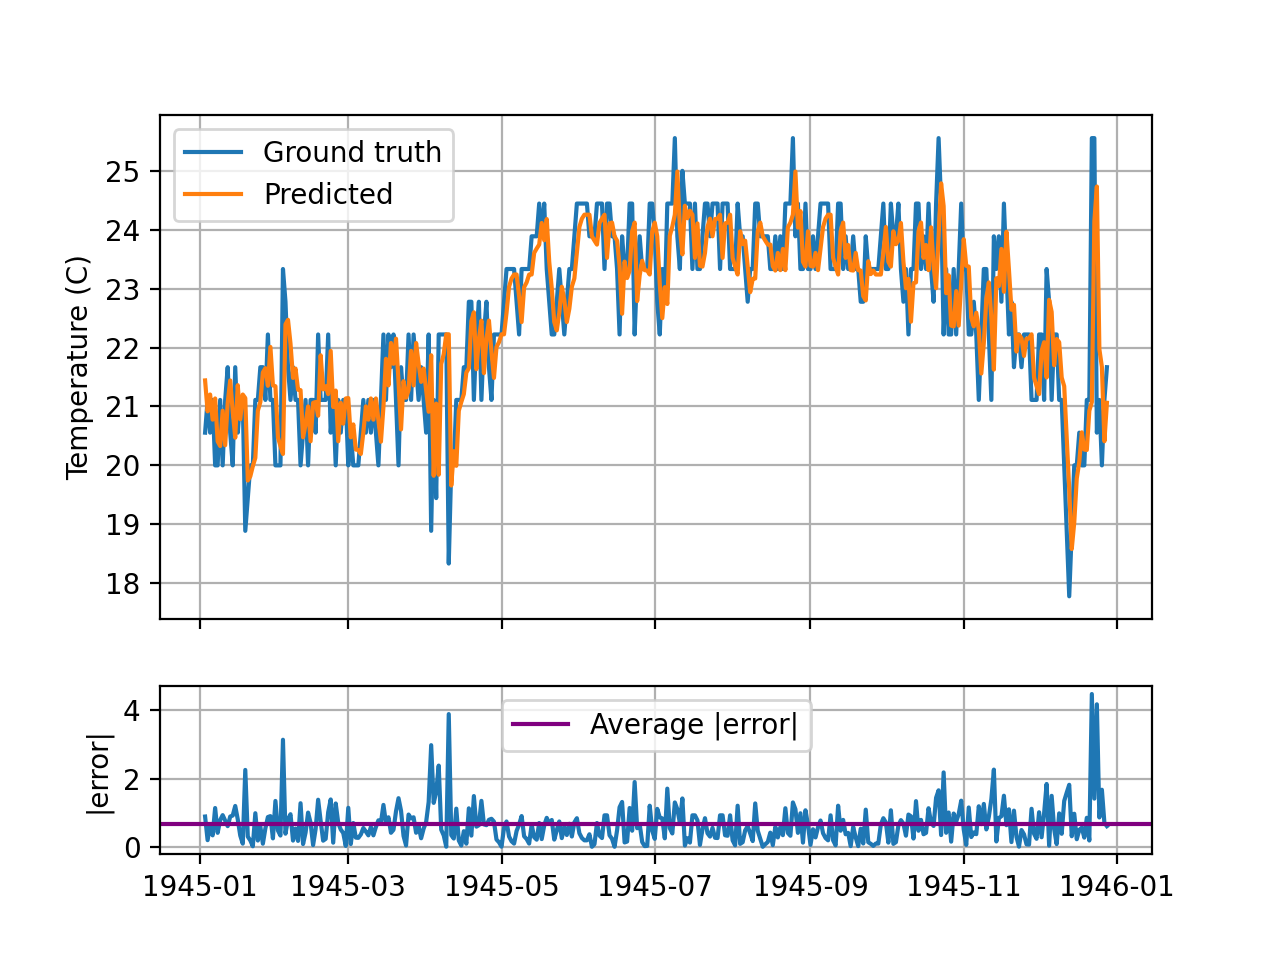

'The average |error| is: 0.65 +- 0.59 degrees Celsius'

In [29]:
model = Ridge(random_state=42)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
y_hat = pd.Series(y_hat, index=y_test.index)
error = y_test - y_hat
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True,gridspec_kw={'height_ratios': [3, 1]})
ax[0].plot(y_test, label="Ground truth")
ax[0].plot(y_hat, label="Predicted")
ax[0].set_ylabel("Temperature (C)")
ax[0].legend()
ax[0].grid()
ax[1].plot(error.abs())
ax[1].set_ylabel("|error|")
ax[1].axhline(error.abs().mean(), color="purple", label = "Average |error|")
ax[1].legend()
ax[1].grid()
f"The average |error| is: {error.abs().mean():.2f} +- {error.abs().std():.2f} degrees Celsius"